In [ ]:
from xflow.extensions.physics.beam import extract_beam_parameters
from xflow.utils.io import scan_files
from xflow.utils.decorator import with_progress
from xflow.data.transform import split_width
from xflow.utils.visualization import plot_image

import matplotlib.pyplot as plt
import cv2

image_shape = []

def get_image_paths(dir):
    image_paths = []
    for d in dir:
        image_paths.extend(scan_files(d, extensions='.png', return_type='str'))
    return image_paths

@with_progress
def run_beam_extraction(image_paths, method='moments'):
    """
    image_paths: list of file paths (str or Path)
    returns: list of whatever extract_beam_parameters returns
    """
    results = []
    for path in image_paths:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # skip unreadable images
        l, r = split_width(img)

        params = extract_beam_parameters(l, method=method, normalize=False)
        if not params:
            continue
        results.append(params)
        
    image_shape.insert(0, l.shape)
    return results


env = 'windows'
if env == 'windows':
    prefix = "C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\"
elif env == 'mac':
    prefix = "/Users/andrewxu/Documents/DataHub/datasets/"


# Wednesday Chromox
# dir = ["/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/12",
#        "/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/11",
#        "/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/10"]
# all_params = run_beam_extraction(get_image_paths(dir), method='moments')

# Friday/Saturday Chromox
dir = [prefix + "2025-11-21/dataset/",
       prefix + "2025-11-22-morning/dataset/",
       ]
all_params = run_beam_extraction(get_image_paths(dir), method='moments')


# Sunday Green Laser
# dir = ["C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23-morning\\dataset\\13",
#        "C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23-morning\\dataset\\15",
#        "C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23-morning\\dataset\\16"]

# Sunday YAG
# all_params = run_beam_extraction(get_image_paths(dir), method='moments')
# # load more dataset/batch (YAG real beam data)
# dir = ["C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23\\dataset\\1",
#        "C:\\Users\\qiyuanxu\\Documents\\DataHub\\datasets\\2025-11-23\\dataset\\7"]
# all_params_yag = run_beam_extraction(get_image_paths(dir), method='moments')

100%|██████████| 13977/13977 [07:01<00:00, 33.18it/s]


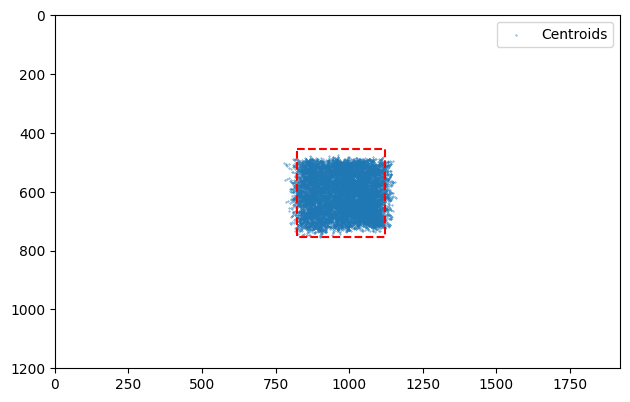

[[823.0, 454.0], [1123.0, 754.0]]

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def find_best_square(all_params, dimension, square_size):
    """
    all_params : list of [h_centroid, v_centroid, h_width, v_width]
    dimension  : (width, height)
    square_size: side length of the square (same units as centroids)

    Returns:
        [[x_top_left, y_top_left], [x_bottom_right, y_bottom_right]]
    """
    width, height = dimension

    # Ensure a sensible integer square size and keep it inside the image
    S = int(round(square_size))
    if S <= 0:
        raise ValueError("square_size must be positive.")
    S = min(S, width, height)

    # Convert to numpy and extract centroids
    arr = np.asarray(all_params, dtype=float)
    if arr.size == 0:
        x0, y0 = 0, 0
        x1, y1 = S, S
        _plot_points_and_square([], [], dimension, (x0, y0, x1, y1))
        return [[float(x0), float(y0)], [float(x1), float(y1)]]

    xs = arr[:, 0]
    ys = arr[:, 1]

    # Keep only points inside the given dimension
    mask = (xs >= 0) & (xs < width) & (ys >= 0) & (ys < height)
    xs_valid = xs[mask]
    ys_valid = ys[mask]

    if xs_valid.size == 0:
        x0, y0 = 0, 0
        x1, y1 = S, S
        _plot_points_and_square(xs, ys, dimension, (x0, y0, x1, y1))
        return [[float(x0), float(y0)], [float(x1), float(y1)]]

    # Map centroids to integer pixel grid (top-left origin)
    xi = np.clip(xs_valid.astype(int), 0, width - 1)
    yi = np.clip(ys_valid.astype(int), 0, height - 1)

    # Build a 2D grid of counts
    grid = np.zeros((height, width), dtype=np.int32)
    np.add.at(grid, (yi, xi), 1)

    # 2D prefix sum (integral image)
    integral = grid.cumsum(axis=0).cumsum(axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode="constant")

    H, W = height, width

    # All SxS window sums in one vectorized shot
    window_sums = (
        integral[S:H + 1, S:W + 1]
        - integral[0:H + 1 - S, S:W + 1]
        - integral[S:H + 1, 0:W + 1 - S]
        + integral[0:H + 1 - S, 0:W + 1 - S]
    )

    # Find the best top-left (y0, x0)
    flat_idx = np.argmax(window_sums)
    y0, x0 = np.unravel_index(flat_idx, window_sums.shape)

    x1 = x0 + S
    y1 = y0 + S

    _plot_points_and_square(xs, ys, dimension, (x0, y0, x1, y1))

    return [[float(x0), float(y0)], [float(x1), float(y1)]]


def _plot_points_and_square(xs, ys, dimension, square_xyxy):
    """Helper: scatter points + dashed square, with (0,0) at top-left."""
    width, height = dimension
    x0, y0, x1, y1 = square_xyxy

    fig, ax = plt.subplots()

    if len(xs) > 0:
        # Smaller scatter points
        ax.scatter(xs, ys, s=0.1, label="Centroids")

    # Dashed red square
    rect_x = [x0, x1, x1, x0, x0]
    rect_y = [y0, y0, y1, y1, y0]
    ax.plot(rect_x, rect_y, linestyle="--", color="red")

    # Set bounding box and origin: top-left = (0, 0)
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.invert_yaxis()
    ax.set_aspect("equal", adjustable="box")

    ax.legend()
    plt.tight_layout()
    plt.show()


H, W = image_shape[0]
find_best_square(all_params, dimension=(W, H), square_size=300)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def find_best_square(all_params, dimension, square_size):
    """
    all_params: list of [h_centroid, v_centroid, h_width, v_width]
    dimension: (width, height)
    square_size: side length of the square (in same units as centroids)
    
    Returns: [[x_top_left, y_top_left], [x_bottom_right, y_bottom_right]]
    """
    width, height = dimension

    # Ensure square_size is not larger than the image
    square_size = min(square_size, width, height)

    # Extract centroids
    arr = np.asarray(all_params, dtype=float)
    xs = arr[:, 0]
    ys = arr[:, 1]

    # Keep only points inside the image
    mask = (0 <= xs) & (xs <= width) & (0 <= ys) & (ys <= height)
    xs = xs[mask]
    ys = ys[mask]

    if xs.size == 0:
        # No valid points: just put the square at (0, 0)
        best_x0, best_y0 = 0.0, 0.0
    else:
        # Candidate top-left positions (include 0 and the right/bottom extremes)
        x_candidates = np.unique(xs)
        y_candidates = np.unique(ys)
        x_candidates = np.concatenate(([0.0], x_candidates, [max(width - square_size, 0.0)]))
        y_candidates = np.concatenate(([0.0], y_candidates, [max(height - square_size, 0.0)]))

        # Clamp candidates so the square stays inside the image
        x_candidates = np.clip(x_candidates, 0, max(width - square_size, 0))
        y_candidates = np.clip(y_candidates, 0, max(height - square_size, 0))

        x_candidates = np.unique(x_candidates)
        y_candidates = np.unique(y_candidates)

        best_count = -1
        best_x0, best_y0 = 0.0, 0.0

        # Brute-force search over candidate squares
        for x0 in x_candidates:
            x1 = x0 + square_size
            in_x = (xs >= x0) & (xs <= x1)
            if not in_x.any():
                continue  # small speed-up

            for y0 in y_candidates:
                y1 = y0 + square_size
                in_square = in_x & (ys >= y0) & (ys <= y1)
                count = in_square.sum()
                if count > best_count:
                    best_count = count
                    best_x0, best_y0 = float(x0), float(y0)

    # Final square coordinates
    x0, y0 = best_x0, best_y0
    x1, y1 = x0 + square_size, y0 + square_size

    # Plot
    fig, ax = plt.subplots()
    ax.scatter(xs, ys, s=10)

    # Draw the square (dashed line)
    rect_x = [x0, x1, x1, x0, x0]
    rect_y = [y0, y0, y1, y1, y0]
    ax.plot(rect_x, rect_y, linestyle="--")

    # Set bounding box and origin: top-left = (0, 0)
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.invert_yaxis()  # so (0,0) is top-left
    ax.set_aspect("equal", adjustable="box")

    plt.tight_layout()
    plt.show()

    return [[x0, y0], [x1, y1]]

H, W = image_shape[0]
find_best_square(all_params, dimension=(W, H), square_size=256)

In [ ]:
all_params

In [ ]:
import matplotlib.pyplot as plt

def plot_beam_parameters(
    all_params,
    point_size=1,
    top_left=None,
    bottom_right=None,
    dpi=200,
    figsize=(5, 5),
    names=None,        # legend labels when multiple datasets
    markerscale=1,
    image_shape=None,  # (height, width) in pixels
):
    """
    all_params:
        - single dataset: list of [h_centroid, v_centroid, h_width, v_width]
        - multiple datasets: list of such lists, one per source
    names:
        - list of legend labels, same length as all_params, used only
          when multiple datasets are passed.
    top_left, bottom_right:
        - given in *pixel* coordinates if image_shape is not None
          top_left     = (x_min, y_max)
          bottom_right = (x_max, y_min)
    image_shape:
        - (height, width) of the image in pixels
        - if given, h_centroid and v_centroid are assumed normalized [0,1]
          and are rescaled to pixel units.
    """

    # Normalize input to a list of (label, dataset)
    if names is None:
        # single dataset, no legend
        groups = [("data", all_params)]
        use_legend = False
    else:
        if len(names) != len(all_params):
            raise ValueError("len(names) must match len(all_params) when multiple datasets are given.")
        groups = list(zip(names, all_params))
        use_legend = True

    # ============================
    # 1) Centroid distribution
    # ============================
    fig1, ax1 = plt.subplots(figsize=figsize, dpi=dpi)

    for label, params in groups:
        h_centroid = [p[0] for p in params]
        v_centroid = [p[1] for p in params]

        # If image_shape is given, convert normalized [0,1] -> pixel units
        if image_shape is not None:
            h_px = [x * image_shape[1] for x in h_centroid]  # width
            v_px = [y * image_shape[0] for y in v_centroid]  # height
        else:
            h_px = h_centroid
            v_px = v_centroid

        if use_legend:
            ax1.scatter(h_px, v_px, s=point_size, label=label)
        else:
            ax1.scatter(h_px, v_px, s=point_size)

    ax1.set_xlabel("h_centroid")
    ax1.set_ylabel("v_centroid")
    ax1.set_title("Centroid distribution")

    # Axis limits: pixel space if image_shape is given, otherwise [0,1]
    if image_shape is not None:
        ax1.set_xlim(0, image_shape[1])  # width
        ax1.set_ylim(0, image_shape[0])  # height
    else:
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)

    ax1.set_aspect('equal', adjustable='box')

    # Rectangle in pixel coordinates (if provided)
    if top_left is not None and bottom_right is not None:
        x_min, y_max = top_left
        x_max, y_min = bottom_right
        width  = x_max - x_min
        height = y_max - y_min

        rect = plt.Rectangle(
            (x_min, y_min),  # bottom-left corner in data coords
            width,
            height,
            fill=False,
            linestyle='--',
            edgecolor='red'
        )
        ax1.add_patch(rect)

    if use_legend:
        ax1.legend(markerscale=markerscale)
        
    # plt.grid()

    # ============================
    # 2) Width distribution (still normalized)
    # ============================
    fig2, ax2 = plt.subplots(figsize=figsize, dpi=dpi)
    for label, params in groups:
        h_width = [p[2] for p in params]
        v_width = [p[3] for p in params]
        if use_legend:
            ax2.scatter(h_width, v_width, s=point_size, label=label)
        else:
            ax2.scatter(h_width, v_width, s=point_size)

    ax2.set_xlabel("h_width")
    ax2.set_ylabel("v_width")
    ax2.set_title("Width distribution")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_aspect('equal', adjustable='box')

    if use_legend:
        ax2.legend(markerscale=markerscale)

    plt.show()


# plot_beam_parameters(
#     [all_params],                 # list of datasets (here only one)
#     names=["Chromox screen"],
#     point_size=0.01,
#     top_left=coords[0],     # already in pixel coords now
#     bottom_right=coords[1],
#     dpi=200,
#     figsize=(6, 6),
#     markerscale=5,
#     image_shape=image_shape[0],     # (height, width)
# )



top_left = [750, 400]
x = 1200-top_left[0]
bottom_right = [1200, top_left[1] + x]

plot_beam_parameters(
    [all_params],                 # list of datasets (here only one)
    names=["Chromox screen"],
    point_size=0.01,
    top_left=top_left,     # already in pixel coords now
    bottom_right=bottom_right,
    dpi=200,
    figsize=(6, 6),
    markerscale=5,
    image_shape=(1, 1),     # (height, width). image_shape[0]
) 